# Objective 

DeepLab V3+모델을 학습하는 코드를 구성하도록 하겠습니다.


In [1]:
import tensorflow as tf
assert int(tf.__version__[0] ) >= 2., "Tensorflow 2.0 버전위에서 동작 가능합니다."

In [2]:
%matplotlib inline
import sys
import os

# Project Path 설정
ROOT_DIR = os.path.dirname(os.path.abspath("./"))
DATA_DIR = os.path.join(ROOT_DIR,"datasets/")
CRACK_DIR = os.path.join(DATA_DIR,"pavement_crack/")
LOG_DIR = os.path.join(ROOT_DIR,"logs/")
os.makedirs(LOG_DIR,exist_ok=True)

# Module 다루기
sys.path.append(ROOT_DIR)

In [3]:
from models import CrackGenerator
import matplotlib.pyplot as plt

<br>

## 1. 데이터 파이프라인 구성하기

---



### (1) 데이터 가져오기

In [4]:
from utils import CrackDataset, label_to_color_image
import numpy as np

# Train Valid Set 구분하기
fnames = os.listdir(os.path.join(CRACK_DIR, "images/"))
np.random.shuffle(fnames)

valid_ratio = 0.1 # Validation Dataset 비율
valid_nums = int(len(fnames) * valid_ratio)

valid_fnames = fnames[:valid_nums]
train_fnames = fnames[valid_nums:]

validset = CrackDataset(CRACK_DIR, fnames=valid_fnames)
trainset = CrackDataset(CRACK_DIR, fnames=train_fnames)

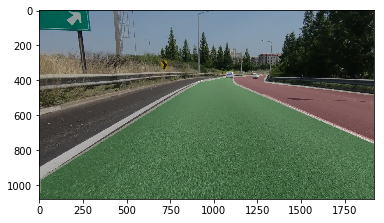

In [5]:
image, label = trainset[10]

plt.imshow(image)
plt.imshow(label_to_color_image(label),alpha=0.3)
plt.show()

### (2) Generator 구성하기

In [6]:
# Generator 구성하기
crop_ratio = 0.7

crop_size = (np.array(image.shape[:2])*crop_ratio).astype(np.int)
print("Random Crop Size 크기 : ",crop_size)

traingen = CrackGenerator(CRACK_DIR,
                          train_fnames, 
                          use_crack=True,
                          use_background=True,
                          batch_size=12,
                          crop_size=crop_size,
                          random_crop=True,
                          random_flip=True,
                          shuffle=True)

validgen = CrackGenerator(CRACK_DIR, 
                          valid_fnames, 
                          batch_size=4, 
                          random_crop=False,
                          random_flip=False,
                          shuffle=False)

# 정상적으로 Generator가 동작하는지 확인
X, Y = traingen[0]

assert np.all(X.shape[1:3] == crop_size), "random crop이 정상적으로 동작하는지 확인"

for y in Y.values():
    assert np.all(y.shape[1:3] == crop_size), "random crop이 정상적으로 동작하는지 확인"


Random Crop Size 크기 :  [ 756 1344]


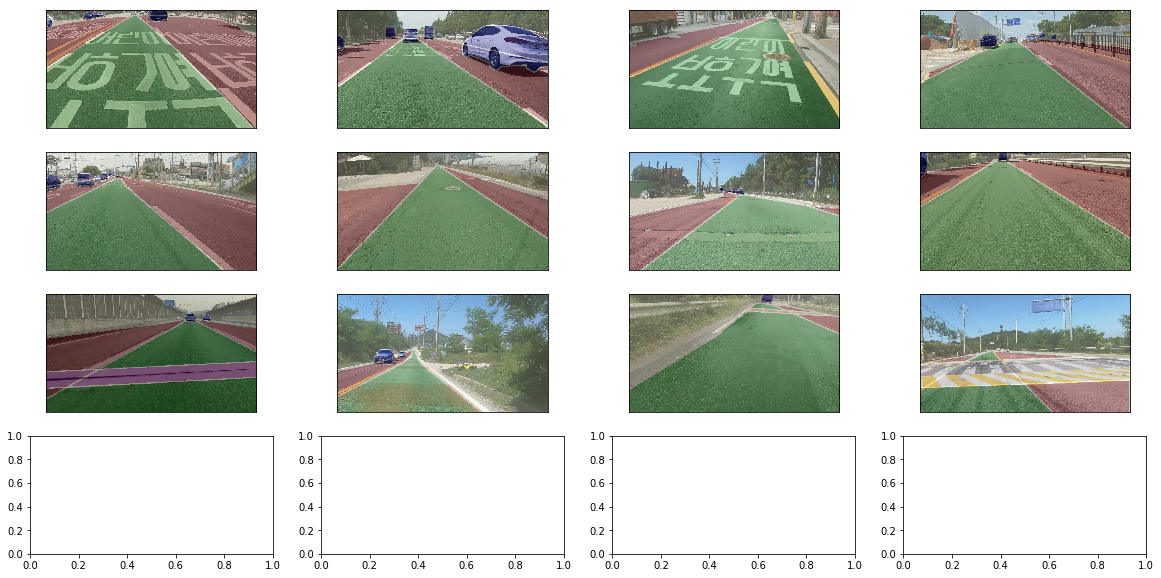

In [7]:
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(4,4)
axes = axes.flatten()

for ax, x, y in zip(axes, X, Y['label_prediction']):
    ax.imshow(x)
    ax.imshow(label_to_color_image(y),alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

<br>

## 2. 모델 구성하기

---

### (1) 모델 가져오기

In [8]:
from tensorflow.keras.utils import plot_model
from models import ModelConfig
from models import DeepLabV3

config = ModelConfig()
config.SEPARATE_BG_CLASSIFIER = True
model = DeepLabV3(config)

/data/anaconda/envs/tf2.0/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


### (2) Loss Function 설정하기

In [9]:
from models.optimizer import AdamW
from models.losses import sparse_categorical_crossentropy_with_ignore
from models.losses import binary_crossentropy_with_ignore
from models.metrics import mean_iou, binary_iou

# Optimizer 정하기
optm = AdamW(lr=7e-4)

# Loss Function 설정하기
loss = {
    "bg_prediction":
    binary_crossentropy_with_ignore(ignore_value=255),
    "label_prediction" : 
    sparse_categorical_crossentropy_with_ignore(ignore_value=255),
    "crack_prediction" : 
    binary_crossentropy_with_ignore(ignore_value=255)}

# Loss Weight 설정하기
loss_weights = {
    "bg_prediction" : 1.0,
    "label_prediction" : 1.0,
    "crack_prediction" : 2.0
}

# Metric 함수 설정하기
metrics={
     "bg_prediction" : binary_iou(thr=0.5),
     "label_prediction" : mean_iou,
     "crack_prediction" : binary_iou(thr=0.5)
}

# 모델 Compile 하기
model.compile(optm, loss=loss,
              loss_weights=loss_weights,
              metrics=metrics)

### (3) Generator Setting하기

In [10]:
# Generator 구성하기
crop_ratio = 0.7

crop_size = (np.array(image.shape[:2])*crop_ratio).astype(np.int)
print("Random Crop Size 크기 : ",crop_size)

traingen = CrackGenerator(CRACK_DIR,
                          train_fnames, 
                          use_crack=True,
                          use_background=True,
                          batch_size=12,
                          crop_size=crop_size,
                          random_crop=True,
                          random_flip=True,
                          shuffle=True)

validgen = CrackGenerator(CRACK_DIR, 
                          valid_fnames, 
                          batch_size=4, 
                          random_crop=False,
                          random_flip=False,
                          shuffle=False)

Random Crop Size 크기 :  [ 756 1344]


### (4) Callback Setting하기

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from datetime import datetime

callbacks = []

# Early Stopping
callbacks.append(EarlyStopping(monitor='val_loss',
                               patience=3,
                               verbose=0))

dirname = datetime.now().strftime("%m%d-%H%M")
save_dir = os.path.join(LOG_DIR,dirname)
os.makedirs(save_dir,exist_ok=True)

# Model Checkpoint
ckpt_path = os.path.join(save_dir,
                         "weights.{val_loss:.2f}-{epoch:02d}.hdf5")
callbacks.append(ModelCheckpoint(ckpt_path, save_best_only=True))

# CSV Logger
callbacks.append(CSVLogger(os.path.join(save_dir, "training.log")))

### (5) Model 학습시키기

In [ ]:
hist = model.fit_generator(traingen,
                           epochs=10,
                           validation_data=validgen)

Epoch 1/10
